In [ ]:
import os
import pickle
from typing import Callable

import numpy as np
from numba import njit

from utils.core import(
    bound_critical_parameter,
    locate_critical_parameter,
    bruteforce_parameter_and_energy_relationship,
)

from utils.utilities import geospace

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from utils.plot import draw_horizons, blend_color
import utils.plot as plot_utils


In [ ]:
### SPECIFY PARAMETERS

# Runge-Kutta parameters
R_MIN = 1.0
R_MAX = 1000.0
STEP = -0.05

# secant method parameters
SECANT_TOLERANCE = 1e-8
SECANT_MAX_ITERS = 50
SECANT_INITIAL_STEP = 1e-6


# critical parameter in the parameter space

MAX_ITERS = 20
ALPHA_MAX = 300 # ad hoc, could be arbirtrarily large
ALPHA_MIN = 0

# locate critical parameter value using binary search

BISECTION_TOLERANCE = 1e-11
BISECTION_MAX_ITERS = 20
BISECTION_ROOT_TOLERANCE = 1e-3

# brutefore parameter range setup
COUNT = 100
OFFSET = 50
RATIO = 0.9

# density profile

RADIUS = 300

shell = "star"

def get_rho(parameter: float) -> Callable[[float], float]:

    amplitude = parameter
    radius = RADIUS
    @njit
    def _rho(x: float) -> float:
            return amplitude if x <= radius else 0.0
    return _rho

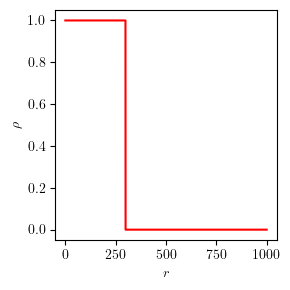

In [3]:
# plot the density profile

unit_rho = get_rho(1)
r_vals = np.arange(R_MAX, R_MIN + STEP, STEP)
unit_rho_vals = [unit_rho(_r) for _r in r_vals]\

plt.figure(figsize=(3, 3))
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.plot(r_vals, unit_rho_vals, color="red")
plt.tight_layout()
plt.show()

In [4]:
forced = False # if True, the code will always run the brute-force search and save results to a file

if not forced and (os.path.isfile("data/" +  shell + "_critical.pkl")):
    with open("data/" +  shell + "_critical.pkl", "rb") as f:
        results = pickle.load(f)

    critical_alpha = results["critical_alpha"]
    critical_parameter = results["critical_parameter"]

else:
    ((parameter_lower, parameter_upper), (alpha_lower, alpha_upper), boolean_success) = bound_critical_parameter(
        _get_rho = get_rho,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        parameter_max = None,
        alpha_max = ALPHA_MAX,
        alpha_min = ALPHA_MIN,
        max_iters = MAX_ITERS,
        minimal_seeked_bound_distance = 1e-3,
        verbose = True,
        scale = 2,
    )

    critical_alpha, critical_parameter, _ = locate_critical_parameter(
        _get_rho = get_rho,
        start = parameter_lower,
        end = parameter_upper,
        alpha_start = alpha_lower,
        alpha_end = alpha_upper,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        bisection_tolerance = BISECTION_TOLERANCE,
        bisection_max_iters = BISECTION_MAX_ITERS,
        bisection_root_tol = BISECTION_ROOT_TOLERANCE
    )

    with open("data/" +  shell + "_critical.pkl", "wb") as f:
        pickle.dump(
            {
                "critical_alpha": critical_alpha,
                "critical_parameter": critical_parameter,
            },
            f,
    )
    

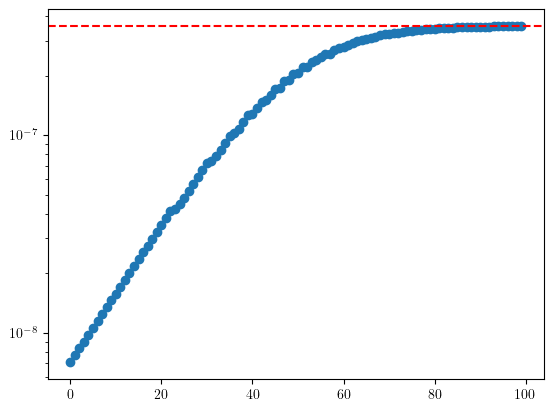

In [5]:

def geospace(start, end, steps=50, ratio=0.9):
    k = np.arange(steps)
    x = start + (end - start) * (1 - ratio**k) / (1 - ratio ** (steps - 1))
    return x

geometric = geospace(critical_parameter / OFFSET, critical_parameter, steps = (COUNT // 2)+1, ratio=RATIO)
logarithmic = np.logspace(np.log10(critical_parameter / OFFSET), np.log10(critical_parameter), COUNT // 2, base=10.0)
parameters = np.sort(np.concatenate((geometric, logarithmic)))[1:] # join, sort and remove first duplicit value



plt.scatter(range(len(parameters)), parameters)
plt.axhline(critical_parameter, color="red", linestyle="--", label="critical parameter")
plt.yscale("log")
plt.show()

In [6]:
# ∇ Ψ + 2πρ Ψ^exponent = 0
exponent = 5 # for scaling
parameter_search_range = parameters.copy()
alpha_search_range = np.linspace(0, 800, 20) # starting guesses, ad hoc, could be arbirtrarily large

In [8]:
forced = False

if not forced and (os.path.isfile("data/" +  shell + "_results.pkl")):
    with open("data/" +  shell + "_results.pkl", "rb") as f:
        results = pickle.load(f)

    ADM_mass_vals = results["E_ADM"]
    rest_mass_vals = results["rest_mass"]
    parameters = results["parameters"]
    horizons = results["horizons"]

else:

    ADM_mass_vals, rest_mass_vals, parameters, horizons = bruteforce_parameter_and_energy_relationship(
        get_rho,
        parameter_search_range,
        alpha_search_range,
        (R_MAX, R_MIN, STEP),
        (SECANT_TOLERANCE, SECANT_MAX_ITERS, SECANT_INITIAL_STEP),
        exponent = exponent,
        unique_root_tolerance=1e-4,
    )

    with open("data/" +  shell + "_results.pkl", "wb") as f:
        pickle.dump(
            {
                "E_ADM": ADM_mass_vals,
                "rest_mass": rest_mass_vals,
                "parameters": parameters,
                "horizons": horizons,
            },
            f,
        )

numerical c. amplitude 3.553134427719513e-07
numerical c. ADM mass: 119.33375244067604


[]

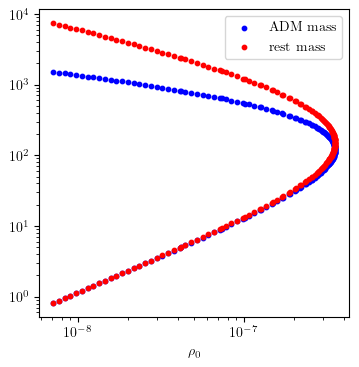

In [9]:
print(f"numerical c. amplitude {critical_parameter}")
print(f"numerical c. ADM mass: {2 * critical_alpha}")

plt.figure(figsize=(4, 4))
plt.scatter(
    parameters,
    ADM_mass_vals,
    label="ADM mass",
    color="blue",
    s=10
)

plt.scatter(
    parameters,
    rest_mass_vals,
    label="rest mass",
    color="red",
    s=10
)

plt.xlabel(r"$\rho_0$")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.plot()

In [10]:
R = RADIUS 

rho_c = 3 / (2 * np.pi * R**2) * 5**5 / 6**6

alpha_c = np.sqrt(5)

offset = 10

exact_lower_branch_alpha_vales = np.logspace(np.log10(alpha_c), np.log10(alpha_c) + 1, 100)
exact_upper_branch_alpha_values = np.logspace(np.log10(alpha_c) - 0.5, np.log10(alpha_c), 100)

exact_upper_branch_rho_values = [3 / (2 * np.pi * R**2) * alpha**10 / (1 + alpha**2)**6 for alpha in exact_upper_branch_alpha_values]
exact_upper_branch_M_ADM_values = [2 * R / alpha**2 for alpha in exact_upper_branch_alpha_values]
exact_upper_branch_M_rest_values = [3 / (4 * alpha**5) * (alpha - alpha**5 + (1 + alpha**2)**3 * np.arctan(1/alpha)) * R for alpha in exact_upper_branch_alpha_values]

exact_lower_branch_rho_values = [3 / (2 * np.pi * R**2) * alpha**10 / (1 + alpha**2)**6 for alpha in exact_lower_branch_alpha_vales]
exact_lower_branch_M_ADM_values = [2 * R / alpha**2 for alpha in exact_lower_branch_alpha_vales]
exact_lower_branch_M_rest_values = [3 / (4 * alpha**5) * (alpha - alpha**5 + (1 + alpha**2)**3 * np.arctan(1/alpha)) * R for alpha in exact_lower_branch_alpha_vales]

halpha = 1
hrho = 3 / (2 * np.pi * R**2) * halpha**10 / (1 + halpha**2)**6
hM_ADM = 2 * R / halpha**2
hrest_M = 3 / (4 * halpha**5) * (halpha - halpha**5 + (1 + halpha**2)**3 * np.arctan(1/halpha)) * R


M_ADM_c = 2 * R / alpha_c**2
M_rest_c = 3 / (4 * alpha_c**5) * (alpha_c - alpha_c**5 + (1 + alpha_c**2)**3 * np.arctan(1/alpha_c))

In [11]:
print(f"exact c. amplitude {rho_c}")
print(f"exact c. ADM mass: {M_ADM_c}")
print(f"exact c. rest mass: {M_rest_c}")
print()

print(f"nemerical c. amplitude {critical_parameter}")
print(f"err {abs(rho_c - critical_parameter)/rho_c *100:.1g}%")
print()
print(f"numerical c. ADM mass: {2 * critical_alpha}")
print(f"err {abs(M_ADM_c - 2*critical_alpha)/ M_ADM_c *100:.1g}%")

exact c. amplitude 3.553377894677161e-07
exact c. ADM mass: 119.99999999999999
exact c. rest mass: 0.4986849952956543

nemerical c. amplitude 3.553134427719513e-07
err 0.007%

numerical c. ADM mass: 119.33375244067604
err 0.6%


In [12]:
_parameters = np.array([parameters[i] for i in np.argsort(ADM_mass_vals)])
_rest_mass_vals = np.array([rest_mass_vals[i] for i in np.argsort(ADM_mass_vals)])
_ADM_mass_vals = np.array([ADM_mass_vals[i] for i in np.argsort(ADM_mass_vals)])

critical_index = np.argmin(np.abs(np.array(_parameters) - critical_parameter))

lower_branch_ADM_mass = _ADM_mass_vals[:critical_index + 1]
lower_branch_rest_mass = _rest_mass_vals[:critical_index + 1]
lower_branch_parameters = _parameters[:critical_index + 1]

upper_branch_ADM_mass = _ADM_mass_vals[critical_index:]
upper_branch_rest_mass = _rest_mass_vals[critical_index:]
upper_branch_parameters = _parameters[critical_index:]


horizon_parameters = [val[0] for val in horizons]
horizon_ADM_mass = [val[1] for val in horizons]
horizon_rest_mass = [val[2] for val in horizons]

horizons_start_at_parameter = np.max(horizon_parameters)

# separate those values with horizons and those without

upper_branch_parameters_with_horizons = [par for par in upper_branch_parameters if par <= horizons_start_at_parameter]
upper_branch_ADM_mass_with_horizons = [mass for mass, par in zip(upper_branch_ADM_mass, upper_branch_parameters) if par <= horizons_start_at_parameter]
upper_branch_rest_mass_with_horizons = [mass for mass, par in zip(upper_branch_rest_mass, upper_branch_parameters) if par <= horizons_start_at_parameter]

upper_branch_without_horizons = [par for par in upper_branch_parameters if par >= horizons_start_at_parameter]
upper_branch_ADM_mass_without_horizons = [mass for mass, par in zip(upper_branch_ADM_mass, upper_branch_parameters) if par >= horizons_start_at_parameter]
upper_branch_rest_mass_without_horizons = [mass for mass, par in zip(upper_branch_rest_mass, upper_branch_parameters) if par >= horizons_start_at_parameter]

first horizon found at approx. parameter 7.8e-08 with ADM energy 6.2e+02 and rest mass 1.5e+03


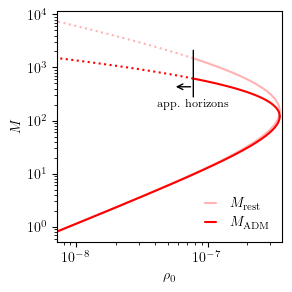

In [ ]:
# scale = 0.4
width = 3.02419  #plot_utils.textwidth * scale * plot_utils.cm_to_inch
height = 3.02419 # width

color = "red"
lighter_color = blend_color(color, 0.3)

fig = plt.figure(figsize=(width, height), tight_layout=True)

draw_horizons(horizons, exponent = exponent, delta=0.6, arrow_length=0.6)

plt.plot(lower_branch_parameters, lower_branch_rest_mass, color=lighter_color, linewidth=1.5, solid_capstyle="round")
plt.plot(upper_branch_without_horizons, upper_branch_rest_mass_without_horizons, color=lighter_color, linewidth=1.5, solid_capstyle="round", label=r"$M_{\text{rest}}$")
plt.plot(upper_branch_parameters_with_horizons, upper_branch_rest_mass_with_horizons, color=lighter_color, linewidth=1.5, linestyle="dotted")

plt.plot(lower_branch_parameters, lower_branch_ADM_mass, color=color, linewidth=1.5, solid_capstyle="round")
plt.plot(upper_branch_without_horizons, upper_branch_ADM_mass_without_horizons, color=color, linewidth=1.5, solid_capstyle="round", label=r"$M_{\text{ADM}}$")
plt.plot(upper_branch_parameters_with_horizons, upper_branch_ADM_mass_with_horizons, color=color, linewidth=1.5, linestyle="dotted")

plt.xlim(left=min(parameters))

plt.xscale("log")
plt.yscale("log")

plt.minorticks_on()

plt.ylabel(r"$M$")
plt.xlabel(r"$\rho_0$")

plt.legend(
    loc="lower right", fancybox=False, 
    framealpha=1, frameon=False, ncol=1, handlelength=0.8, handletextpad=1, columnspacing=0.8, 
)
plt.savefig("img/" + shell + "_sol_curve.pdf", bbox_inches="tight", dpi=300)

C:\Users\josef\AppData\Local\Temp\ipykernel_182312\838495826.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("img/cds_ADM_mass_vs_density_subplot.pdf", bbox_inches="tight", dpi=300)
C:\Users\josef\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


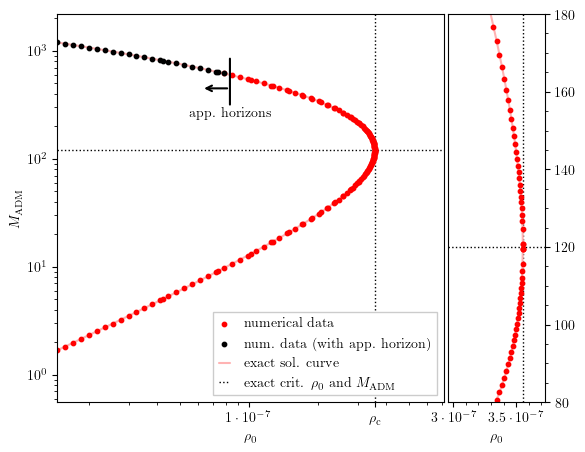

In [ ]:
def formatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    base, exponent = f"{x:.2e}".split("e")
    return r"${:.2g} \cdot 10^{{{}}}$".format(float(base), int(exponent))

def fformatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    base, exponent = f"{x:.4e}".split("e")
    return r"${:.4g} \cdot 10^{{{}}}$".format(float(base), int(exponent))

cm = 1/2.54
scale = 0.8

width_main  = 16 * cm * scale
width_zoom  = 16 * cm * 0.2
height      = width_main 

fig, (ax_main, ax_zoom) = plt.subplots(
    1, 2,
    figsize=(width_main + width_zoom, height),
    gridspec_kw={"width_ratios": [0.8, 0.2], "wspace": 0.02},
    tight_layout=True
)


lighter_red = blend_color("red", 0.3)
ax = ax_main


ax.scatter(lower_branch_parameters, lower_branch_ADM_mass, color="red", s=10, zorder=1, label="numerical data")
ax.scatter(upper_branch_without_horizons, upper_branch_ADM_mass_without_horizons, color="red", s=10, zorder=1)
ax.scatter(upper_branch_parameters_with_horizons, upper_branch_ADM_mass_with_horizons,
           color="black", s=10, label="num. data (with app. horizon)", zorder=1)


ax.plot(exact_upper_branch_rho_values,   exact_upper_branch_M_ADM_values,
        color=lighter_red, linewidth=1.5, solid_capstyle="round", zorder=0.9, label="exact sol. curve")
ax.plot(exact_lower_branch_rho_values,   exact_lower_branch_M_ADM_values,
        color=lighter_red, linewidth=1.5, solid_capstyle="round", zorder=0.9)

delta = 0.5
arrow_length = 0.5
ax.annotate("", xy=(hrho, (1 - delta) * hM_ADM),
            xytext=(hrho, (1 + delta) * hM_ADM),
            arrowprops=dict(arrowstyle="-", lw=1.5, ls="-", color="black"))
ax.annotate("", xy=(hrho, (1 - 0.5*delta) * hM_ADM),
            xytext=(hrho * (1 - 0.5*arrow_length), (1 - 0.5*delta)*hM_ADM),
            arrowprops=dict(arrowstyle="<-", lw=1.5, ls="-", color="black"))
ax.text(hrho, (1 - delta) * hM_ADM, "app. horizons",
        ha="center", va="top")

ax.set_xscale("log")
ax.set_yscale("log")
ax.minorticks_on()
ax.set_xlim(left=np.min(exact_upper_branch_rho_values), right=rho_c * 2)
ax.set_xlabel(r"$\rho_0$")
ax.set_ylabel(r"$M_{\text{ADM}}$")

# add extra tick for rho_c
xticks = [1e-7, rho_c]
xlabels = [formatter(1e-7, 0), r"$\rho_{\text{c}}$"]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

ax.axhline(y=M_ADM_c, color="black", linestyle="dotted",
           label=r"exact crit. $\rho_0$ and $M_{\text{ADM}}$", zorder=0.8, linewidth=1)
ax.axvline(x=rho_c,   color="black", linestyle="dotted", zorder=0.8, linewidth=1)

ax.legend(
    loc="lower right", fancybox=False,
    framealpha=1, frameon=True, ncol=1,
    handlelength=0.8, handletextpad=1, columnspacing=0.8
)



# , bbox_to_anchor=(1.45, -0.4)

ax = ax_zoom


ax.scatter(lower_branch_parameters, lower_branch_ADM_mass, color="red", s=10, zorder=1)
ax.scatter(upper_branch_without_horizons, upper_branch_ADM_mass_without_horizons,
           color="red", s=10, zorder=1)
ax.plot(exact_upper_branch_rho_values,   exact_upper_branch_M_ADM_values,
        color=lighter_red, linewidth=1.5, solid_capstyle="round", zorder=0.9)
ax.plot(exact_lower_branch_rho_values,   exact_lower_branch_M_ADM_values,
        color=lighter_red, linewidth=1.5, solid_capstyle="round", zorder=0.9)

ax.set_xlim(rho_c/1.2, rho_c*1.05)
ax.set_ylim(M_ADM_c/1.5, M_ADM_c*1.5)
ax.xaxis.set_major_formatter(FuncFormatter(formatter))

ax.axhline(y=M_ADM_c, color="black", linestyle="dotted", zorder=0.8, linewidth=1)
ax.axvline(x=rho_c,   color="black", linestyle="dotted", zorder=0.8, linewidth=1)

ax.yaxis.tick_right()

ax.minorticks_on()
ax.set_xlabel(r"$\rho_0$")

# xticks = [rho_c]


# xlabels = [formatter(rho_c, 0)]


# ax_zoom.set_xticks(xticks)
# ax_zoom.set_xticklabels(xlabels)

# # (optionally turn off the default formatter)
# ax_zoom.xaxis.set_major_formatter(plt.NullFormatter())

plt.savefig("img/cds_ADM_mass_vs_density_subplot.pdf", bbox_inches="tight", dpi=300)
plt.show()
